# E-commerce Sales Analysis (UK Online Retail)

**Objective:** Analyze sales trends, customer segments, and product associations to inform marketing and merchandising strategies.

**Dataset:** [Online Retail Data from Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

---

## Step 1: Setup
Load libraries and configure settings for display and plotting.

In [1]:
# Step 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid")

## Step 2: Load Data
Import raw dataset from Kaggle and preview initial rows.

In [2]:
# Step 2: Load Data
df = pd.read_csv("/kaggle/input/ecommerce-data/data.csv", encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


## Step 3: Initial Audit
Check shape, data types, missing values, and duplicates to understand data health.

In [3]:
print(df.shape)
print(df.info())
df.isnull().sum()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Step 4: Data Cleaning & Feature Engineering
- Remove cancellations (`InvoiceNo` starting with "C")
- Remove negative quantities and zero/negative prices
- Remove duplicates
- Create:
    - `LineTotal` = Quantity × UnitPrice
    - `InvoiceYearMonth`
    - `InvoiceDate_only`

In [4]:
# Remove cancellations
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantity/price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove duplicates
df.drop_duplicates(inplace=True)

# Create LineTotal
df['LineTotal'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDate_only'] = df['InvoiceDate'].dt.date

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,LineTotal,InvoiceYearMonth,InvoiceDate_only
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12,2010-12-01


## Step 5: Monthly KPIs
Aggregate revenue, orders, and AOV (average order value) by month.

In [5]:
monthly = df.groupby('InvoiceYearMonth').agg({
    'LineTotal': 'sum',
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique'
}).reset_index()

monthly.rename(columns={'LineTotal': 'Revenue', 'InvoiceNo': 'Orders', 'CustomerID': 'Active_Customers'}, inplace=True)
monthly['AOV'] = monthly['Revenue'] / monthly['Orders']

monthly

,InvoiceYearMonth,Revenue,Orders,Active_Customers,AOV
0,2010-12,821452.73,1559,885,526.91
1,2011-01,689811.61,1086,741,635.19
2,2011-02,522545.56,1100,758,475.04
3,2011-03,716215.26,1454,974,492.58
4,2011-04,536968.49,1246,856,430.95
5,2011-05,769296.61,1681,1056,457.64
6,2011-06,760547.01,1533,991,496.12
7,2011-07,718076.12,1475,949,486.83
8,2011-08,757841.38,1361,935,556.83
9,2011-09,1056435.19,1837,1266,575.09


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with p

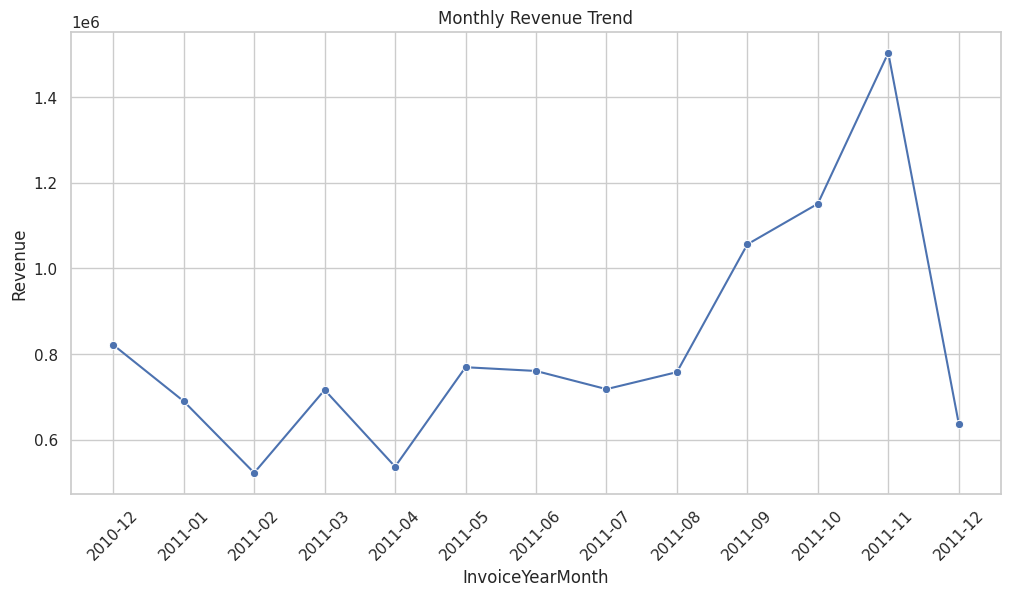

In [6]:
# Convert to string for plotting
monthly['InvoiceYearMonth'] = monthly['InvoiceYearMonth'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x='InvoiceYearMonth', y='Revenue', marker='o')
plt.title("Monthly Revenue Trend")
plt.xticks(rotation=45)
plt.show()

## Step 6: Top Products & Countries
Identify top-selling products by revenue and top countries (excluding UK).

In [7]:
top_products = df.groupby('Description')['LineTotal'].sum().sort_values(ascending=False).head(10)
top_countries = df[df['Country'] != 'United Kingdom'].groupby('Country')['LineTotal'].sum().sort_values(ascending=False).head(10)

top_products, top_countries

(Description
 DOTCOM POSTAGE                       206248.77
 REGENCY CAKESTAND 3 TIER             174156.54
 PAPER CRAFT , LITTLE BIRDIE          168469.60
 WHITE HANGING HEART T-LIGHT HOLDER   106236.72
 PARTY BUNTING                         99445.23
 JUMBO BAG RED RETROSPOT               94159.81
 MEDIUM CERAMIC TOP STORAGE JAR        81700.92
 POSTAGE                               78101.88
 Manual                                77752.82
 RABBIT NIGHT LIGHT                    66870.03
 Name: LineTotal, dtype: float64,
 Country
 Netherlands   285446.34
 EIRE          283140.52
 Germany       228678.40
 France        209625.37
 Australia     138453.81
 Spain          61558.56
 Switzerland    57067.60
 Belgium        41196.34
 Sweden         38367.83
 Japan          37416.37
 Name: LineTotal, dtype: float64)

## Step 7 — RFM Segmentation (Alternative Scoring)

Since some customers have identical Recency, Frequency, or Monetary values,
`pd.qcut` can cause bin errors.  
We will instead assign scores based on percentile ranks:
- Lowest Recency → Highest score (4)
- Highest Frequency → Highest score (4)
- Highest Monetary → Highest score (4)

In [8]:
# Create a total value per row = Quantity × UnitPrice
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

# Quick check
df[['Quantity','UnitPrice','TotalSum']].head()

,Quantity,UnitPrice,TotalSum
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [9]:
import datetime as dt

# Snapshot date = one day after the last invoice
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                    # Frequency
    'TotalSum': 'sum'                                        # Monetary
})

# Rename
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalSum': 'Monetary'}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.00,326,1,77183.60
12347.00,2,182,4310.00
12348.00,75,31,1797.24
12349.00,19,73,1757.55
12350.00,310,17,334.40


In [10]:
# R_Score: lower recency → higher score
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4,3,2,1])

# F_Score: higher frequency → higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])

# M_Score: higher monetary → higher score
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1,2,3,4])

# Combine
rfm['RFM_Segment'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

# Show top 10 customers
rfm.sort_values('RFM_Score', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
14367.00,8,521,9227.82,4,4,4,444,12
13468.00,2,302,5704.97,4,4,4,444,12
17644.00,1,157,2895.64,4,4,4,444,12
16474.00,7,337,1810.65,4,4,4,444,12
14390.00,10,284,4642.57,4,4,4,444,12
15484.00,1,187,3590.41,4,4,4,444,12
14388.00,10,186,3212.84,4,4,4,444,12
18097.00,8,106,2662.40,4,4,4,444,12
17757.00,1,740,5593.39,4,4,4,444,12


## Step 8: Cohort Analysis
Measure retention rate over time by grouping customers into cohorts based on their first purchase.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


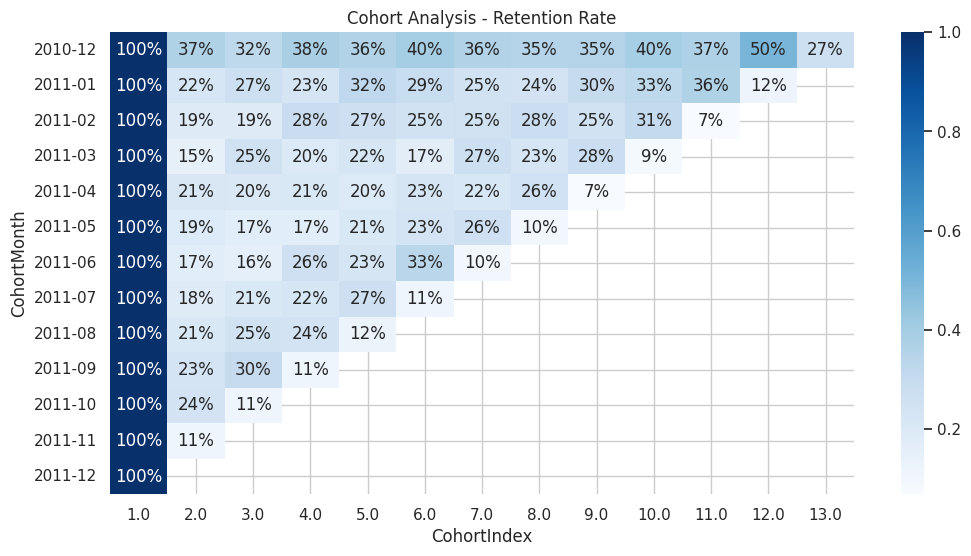

In [11]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

def get_month_diff(d1, d2):
    return (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month) + 1

df['CohortIndex'] = get_month_diff(df['InvoiceDate'], df['CohortMonth'].dt.to_timestamp())

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)

plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Analysis - Retention Rate')
plt.show()

## Step 9: Market Basket Analysis (Optimized)
Find frequently purchased product combinations.
To save memory:
- Only keep items sold in >= 50 orders
- Focus on UK market
- Use product Description for readability

In [12]:
uk = df[df['Country'] == 'United Kingdom'].copy()

order_counts = uk.groupby('Description')['InvoiceNo'].nunique()
popular_items = order_counts[order_counts >= 50].index

uk_pop = uk[uk['Description'].isin(popular_items)].copy()

basket = (uk_pop.groupby(['InvoiceNo','Description'])['Quantity']
          .sum().unstack().fillna(0))
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

freq_items = apriori(basket_binary, min_support=0.02, use_colnames=True)
rules = association_rules(freq_items, metric="lift", min_threshold=1.1)\
        .sort_values(['lift','confidence'], ascending=False)

rules['antecedents'] = rules['antecedents'].apply(lambda s: ', '.join(list(s)))
rules['consequents'] = rules['consequents'].apply(lambda s: ', '.join(list(s)))

rules[['antecedents','consequents','support','confidence','lift']].head(20)

/tmp/ipykernel_13/30571085.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
199,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN HEART CHRISTMAS SCANDINAVIAN,0.02,0.77,26.84
198,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,0.02,0.72,26.84
200,"ROSES REGENCY TEACUP AND SAUCER , GREEN REGENC...",PINK REGENCY TEACUP AND SAUCER,0.03,0.70,17.81
205,PINK REGENCY TEACUP AND SAUCER,"ROSES REGENCY TEACUP AND SAUCER , GREEN REGENC...",0.03,0.70,17.81
201,"ROSES REGENCY TEACUP AND SAUCER , PINK REGENCY...",GREEN REGENCY TEACUP AND SAUCER,0.03,0.90,17.23
204,GREEN REGENCY TEACUP AND SAUCER,"ROSES REGENCY TEACUP AND SAUCER , PINK REGENCY...",0.03,0.53,17.23
202,"PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY ...",ROSES REGENCY TEACUP AND SAUCER,0.03,0.85,15.89
203,ROSES REGENCY TEACUP AND SAUCER,"PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY ...",0.03,0.51,15.89
35,PINK REGENCY TEACUP AND SAUCER,GREEN REGENCY TEACUP AND SAUCER,0.03,0.82,15.66
34,GREEN REGENCY TEACUP AND SAUCER,PINK REGENCY TEACUP AND SAUCER,0.03,0.62,15.66


## Step 10: Save Outputs
Export cleaned data and analysis results for Tableau.

In [13]:
df.to_csv("cleaned_ecommerce.csv", index=False)
rfm.to_csv("rfm_segments.csv", index=False)
rules.to_csv("basket_rules.csv", index=False)

In [14]:
# Monthly KPIs
monthly = (df.groupby(pd.Grouper(key='InvoiceDate', freq='MS'))
             .agg(Revenue=('LineTotal','sum'),
                  Orders=('InvoiceNo','nunique'),
                  Active_Customers=('CustomerID','nunique'))
             .reset_index())
monthly['AOV'] = monthly['Revenue'] / monthly['Orders']
monthly.rename(columns={'InvoiceDate':'InvoiceMonth'}, inplace=True)
monthly.to_csv("/kaggle/working/ecom_monthly_kpis.csv", index=False)

# Country revenue
country_rev = (df.groupby('Country')
                 .agg(Revenue=('LineTotal','sum'),
                      Orders=('InvoiceNo','nunique'))
                 .reset_index()
                 .sort_values('Revenue', ascending=False))
country_rev.to_csv("/kaggle/working/ecom_country_rev.csv", index=False)

# Top products by revenue (top 20)
top_products_rev = (df.groupby('Description')['LineTotal']
                      .sum().reset_index()
                      .sort_values('LineTotal', ascending=False)
                      .head(20)
                      .rename(columns={'LineTotal':'Revenue'}))
top_products_rev.to_csv("/kaggle/working/ecom_top_products_rev.csv", index=False)

## Insights & Recommendations
- Revenue peaks in Q4 → leverage holiday campaigns.
- Top products are staple gift items → bundle for upselling.
- RFM shows a small group of loyal, high-value customers → reward them.
- Cohort retention drops sharply after month 2 → improve onboarding emails.
- Basket analysis suggests cross-selling between frequently co-purchased items.
